In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,  LSTM, CuDNNLSTM # cuda version of lstm

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print(x_train.shape)

(60000, 28, 28)


In [0]:
x_train = x_train/255.0
x_test = x_test/255.0

In [0]:
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1:]),
                    activation='relu', 
                    return_sequences=True # return sequences of you want to another lstm else no need
                   ))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [0]:
model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(x_train.shape[1:]),
                    return_sequences=True # return sequences of you want to another lstm else no need
                   ))
model.add(Dropout(0.2))

model.add(CuDNNLSTM(128)) # cudnnlstm uses tanh by default.
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [10]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 49s 825us/step - loss: 0.3788 - acc: 0.8843 - val_loss: 0.1202 - val_acc: 0.9631
Epoch 2/10
60000/60000 [==============================] - 45s 752us/step - loss: 0.1422 - acc: 0.9614 - val_loss: 0.0878 - val_acc: 0.9741
Epoch 3/10
60000/60000 [==============================] - 45s 742us/step - loss: 0.1063 - acc: 0.9711 - val_loss: 0.1079 - val_acc: 0.9688
Epoch 4/10
60000/60000 [==============================] - 45s 743us/step - loss: 0.0921 - acc: 0.9753 - val_loss: 0.0805 - val_acc: 0.9767
Epoch 5/10
60000/60000 [==============================] - 44s 738us/step - loss: 0.0760 - acc: 0.9788 - val_loss: 0.0682 - val_acc: 0.9798
Epoch 6/10
60000/60000 [==============================] - 44s 734us/step - loss: 0.0677 - acc: 0.9814 - val_loss: 0.0623 - val_acc: 0.9833
Epoch 7/10
60000/60000 [==============================] - 44s 741us/step - loss: 0.0627 - acc: 0.9832 - val_loss: 0.

In [11]:
history

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')


def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

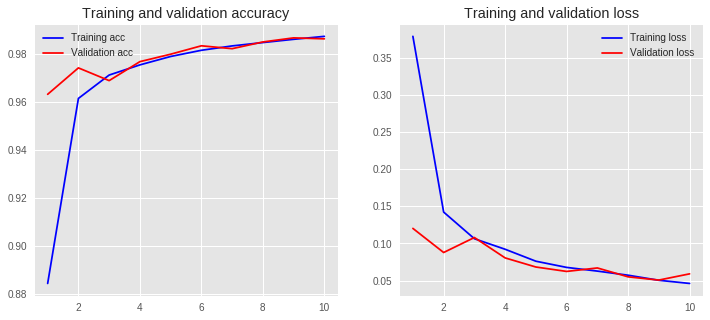

In [13]:
plot_history(history)

using RNN on cryptocurrency

In [16]:
print("!wget https://pythonprogramming.net/static/downloads/machine-learning-data/crypto_data.zip")

!wget https://pythonprogramming.net/static/downloads/machine-learning-data/crypto_data.zip


In [21]:
%%bash
echo "unzip crypto_data.zip"
ls -ltr crypto_data

unzip crypto_data.zip
total 24876
-rw-r--r-- 1 root root 6658291 Aug 25 11:42 BTC-USD.csv
-rw-r--r-- 1 root root 6223190 Aug 25 11:42 LTC-USD.csv
-rw-r--r-- 1 root root 6657679 Aug 25 11:42 ETH-USD.csv
-rw-r--r-- 1 root root 5925778 Aug 27 10:23 BCH-USD.csv


In [0]:
import pandas as pd
import os
from sklearn import  preprocessing
from collections import deque
import random
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,  LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [0]:
df = pd.read_csv("crypto_data/LTC-USD.csv", names=["time", "low", "high", "open", "close", "volume"])

In [25]:
df.head()

,time,low,high,open,close,volume
0,1528968660,96.580002,96.589996,96.589996,96.580002,9.647200
1,1528968720,96.449997,96.669998,96.589996,96.660004,314.387024
2,1528968780,96.470001,96.570000,96.570000,96.570000,77.129799
3,1528968840,96.449997,96.570000,96.570000,96.500000,7.216067
4,1528968900,96.279999,96.540001,96.500000,96.389999,524.539978


In [0]:
SEQ_LEN = 60
FUTURE_PERIOD_PREDICT = 3
RATIO_TO_PREDICT = "LTC"
EPOCHS = 10
BATCH_SIZE = 64
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

In [0]:
def classify(current, future):
  if float(future) > float(current):
    return 1
  else:
    return 0

In [63]:
main_df = pd.DataFrame()

ratios = ["BTC", "LTC", "ETH", "BCH"]
for ratio in ratios:
  dataset = f"crypto_data/{ratio}-USD.csv"
  
  df = pd.read_csv(dataset, names=["time", "low", "high", "open", "close", "volume"])
  df.rename(columns={"close": f"{ratio}_close", "volume": f"{ratio}_volume"}, inplace=True)
  
  df.set_index("time", inplace=True)
  
  df = df[[f"{ratio}_close", f"{ratio}_volume"]]
  
  if len(main_df) == 0:
    main_df = df
  else:
    main_df = main_df.join(df)
    
    
main_df["future"] = main_df[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT)

main_df["target"] = list(map(classify, main_df[f"{RATIO_TO_PREDICT}_close"], main_df["future"]))
                                                                                     
print(main_df[[f"{RATIO_TO_PREDICT}_close", "future", "target"]].head())

            LTC_close     future  target
time                                    
1528968660  96.580002  96.500000       0
1528968720  96.660004  96.389999       0
1528968780  96.570000  96.519997       0
1528968840  96.500000  96.440002       0
1528968900  96.389999  96.470001       1


In [0]:
times = sorted(main_df.index.values)

In [65]:
last_5_percent = times[-int(0.05 * len(times))]
print(last_5_percent)

1534922100


In [0]:
def preprocess(df):
  df = df.drop("future", axis=1)
  
  for col in df.columns:
    if col != "target":
      df[col] = df[col].pct_change()
      df.dropna(inplace=True)
      df[col] = preprocessing.scale(df[col].values)
      
  df.dropna(inplace=True)
  
  sequential_data = []
  prev_days = deque(maxlen=SEQ_LEN)
  print(df.head())
  
  for i in df.values:
    prev_days.append([n for n in i[:-1]])
    if len(prev_days) == SEQ_LEN:
      sequential_data.append([np.array(prev_days), i[-1]])
      
  random.shuffle(sequential_data)
  
  buys = []
  sells = []
  
  for seq, target in sequential_data:
    if target ==  0:
      sells.append([seq, target])
    else:
      buys.append([seq, target])
      
  random.shuffle(buys)
  random.shuffle(sells)
  
  lower = min(len(buys), len(sells))
  
  buys = buys[:lower]
  sells = sells[:lower]
  
  sequential_data = buys + sells
  random.shuffle(sequential_data)
  
  X = []
  y = []
  
  for seq, target in sequential_data:
    X.append(seq)
    y.append(target)
    
  return np.array(X), y
    

In [0]:
validation_main_df = main_df[(main_df.index >= last_5_percent)]
main_df = main_df[(main_df.index < last_5_percent)]

In [68]:
train_x, train_y = preprocess(main_df)
validation_x, validation_y = preprocess(validation_main_df)

            BTC_close  BTC_volume  LTC_close  LTC_volume  ETH_close  \
time                                                                  
1528969140  -0.002513   -0.078919  -0.540429   -0.117090   0.004601   
1528969200  -0.229992    0.003410   0.004048   -0.118307   0.004601   
1528969260  -0.000830   -0.074039   0.004048   -0.072997   0.021273   
1528969320   0.116299   -0.049626   0.004048   -0.108241   0.004601   
1528969380   0.000937   -0.082052   0.004048   -0.048516   0.004601   

            ETH_volume  BCH_close  BCH_volume  target  
time                                                   
1528969140   -0.047838   0.011062   -0.006217       0  
1528969200   -0.045377   0.257552   -0.005884       0  
1528969260   -0.032900   0.265415   -0.006200       1  
1528969320   -0.049530   0.455951   -0.005898       1  
1528969380   -0.032916   0.527186   -0.006206       0  
            BTC_close  BTC_volume  LTC_close  LTC_volume  ETH_close  \
time                                   

In [69]:
print(f"training data: {len(train_x)} validation: {len(validation_x)}")
print(f"Dont sells: {train_y.count(0)} buys: {train_y.count(1)}")
print(f"Validation Dont sells: {validation_y.count(0)} buys: {validation_y.count(1)}")

training data: 69188 validation: 3062
Dont sells: 34594 buys: 34594
Validation Dont sells: 1531 buys: 1531


In [0]:
model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, return_sequences=True)) # cudnnlstm uses tanh by default.
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128)) # cudnnlstm uses tanh by default.
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [0]:
!mkdir model

In [0]:
tensorboard = TensorBoard(log_dir=f"logs/{NAME}")

filepath = "RNN_Final-{epoch:02d}-{val_acc:.3f}"
checkpoint = ModelCheckpoint("model/{}.model".format(filepath, monitor="val_acc", verbose=1, save_best_only=True, model="max"))

In [75]:
history = model.fit(train_x, train_y,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=(validation_x, validation_y), 
                    callbacks=[tensorboard, checkpoint])

Train on 69188 samples, validate on 3062 samples
Epoch 1/10
69188/69188 [==============================] - 76s 1ms/step - loss: 0.6872 - acc: 0.5447 - val_loss: 0.6826 - val_acc: 0.5598
Epoch 2/10
69188/69188 [==============================] - 74s 1ms/step - loss: 0.6828 - acc: 0.5601 - val_loss: 0.6760 - val_acc: 0.5683
Epoch 3/10
69188/69188 [==============================] - 72s 1ms/step - loss: 0.6805 - acc: 0.5647 - val_loss: 0.6820 - val_acc: 0.5630
Epoch 4/10
69188/69188 [==============================] - 72s 1ms/step - loss: 0.6791 - acc: 0.5684 - val_loss: 0.6833 - val_acc: 0.5581
Epoch 5/10
69188/69188 [==============================] - 73s 1ms/step - loss: 0.6767 - acc: 0.5719 - val_loss: 0.6785 - val_acc: 0.5637
Epoch 6/10
69188/69188 [==============================] - 71s 1ms/step - loss: 0.6743 - acc: 0.5775 - val_loss: 0.6774 - val_acc: 0.5650
Epoch 7/10
69188/69188 [==============================] - 70s 1ms/step - loss: 0.6710 - acc: 0.5877 - val_loss: 0.6902 - val_acc:

In [77]:
# score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

# save model
model.save("model/{}".format(NAME))

Test loss:  0.7046369641610487
Test accuracy:  0.5555192683741285
